In [6]:
# 0. imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [9]:
# -------------------------
# 1. Load, robust-clean & rename columns
# -------------------------
path = "dataset/RBI_Liabilities and Assets.csv"   # adjust path if required
df_raw = pd.read_csv(path, header=0, low_memory=False)

# Normalize column names (strip, collapse multiple spaces, replace slashes)
df_raw.columns = [str(c).strip().replace('\n',' ').replace('/', '_').replace('  ', ' ') for c in df_raw.columns]

# If your dataset already uses the new names, this rename dict will be harmless; otherwise it maps likely originals.
rename_map = {
    # Date
    'Week Ended': 'Week_Ended',
    'Week_Ended': 'Week_Ended',
    # A group
    'Notes Issued': 'A_Note_Issued',
    'A_Note_ Issued': 'A_Note_Issued',
    'Notes in Circulation': 'A1_Notes_in_Circulation',
    'Notes held in Banking Department': 'A2_Notes_Held_in_Banking_Department',
    # B group (Deposits)
    'Deposits': 'B_Deposits',
    'Deposits_Central_Government': 'B1_Deposits_Central_Government',
    'Central Government': 'B1_Deposits_Central_Government',
    'Market Stabilisation Scheme': 'B2_Deposits_Market_Stabilisation_Scheme',
    'Deposits_MSS': 'B2_Deposits_Market_Stabilisation_Scheme',
    'State Governments': 'B3_Deposits_State_Governments',
    'Scheduled Commercial Banks': 'B4_Deposits_Scheduled_Commercial_Banks',
    'Scheduled State Co-operative Banks': 'B5_Deposits_Scheduled_State_Cooperative_Banks',
    'Other Banks': 'B6_Deposits_Other_Banks',
    'Others': 'B7_Deposits_Others',
    # C Other Liabilities
    'Other Liabilities': 'C_Other_Liabilities',
    # D Total
    'Total Liabilities /Assets': 'D_Total_Liabilities_OR_Assets',
    'Total Liabilities /Assets ': 'D_Total_Liabilities_OR_Assets',
    'Foreign Currency Assets': 'D1_Foreign_Currency_Assets',
    'Gold': 'D2_Gold',
    'Rupee Securities (including Treasury Bills)': 'D3_Rupee_Securities',
    'Rupee Securities': 'D3_Rupee_Securities',
    # E Loans and Advances
    'Loans and Advances': 'E_Loans_and_Advances',
    'Central Government': 'E1_Loans_Central_Government',   # note: ambiguity resolved if both deposit & loan same name
    'State Governments ': 'E2_Loans_State_Governments',
    'NABARD': 'E3_Loans_NABARD',
    'Scheduled Commercial Banks': 'E4_Loans_Scheduled_Commercial_Banks',
    'Scheduled State Co-op.Banks': 'E5_Loans_Scheduled_State_Cooperative_Banks',
    'Others.1': 'E6_Loans_Others',
    # F Investments
    'Investments': 'F_Investments',
    # G Other Assets
    'Other Assets': 'G_Other_Assets'
}

# Apply rename_map where keys exist in df_raw
cols = df_raw.columns.tolist()
applied_rename = {c: rename_map[c] for c in cols if c in rename_map}
df_raw = df_raw.rename(columns=applied_rename)

# After rename, if original already had new names, ensure consistency by standardizing exact names provided by you:
# (This block ensures group columns are named exactly; if some are missing you can fill them later.)
expected_cols = [
    'Week_Ended','A_Note_Issued','A1_Notes_in_Circulation','A2_Notes_Held_in_Banking_Department',
    'B_Deposits','B1_Deposits_Central_Government','B2_Deposits_Market_Stabilisation_Scheme',
    'B3_Deposits_State_Governments','B4_Deposits_Scheduled_Commercial_Banks',
    'B5_Deposits_Scheduled_State_Cooperative_Banks','B6_Deposits_Other_Banks','B7_Deposits_Others',
    'C_Other_Liabilities','D_Total_Liabilities_OR_Assets','D1_Foreign_Currency_Assets','D2_Gold','D3_Rupee_Securities',
    'E_Loans_and_Advances','E1_Loans_Central_Government','E2_Loans_State_Governments','E3_Loans_NABARD',
    'E4_Loans_Scheduled_Commercial_Banks','E5_Loans_Scheduled_State_Cooperative_Banks','E6_Loans_Others',
    'F_Investments','G_Other_Assets'
]

# 1a. Clean numeric strings into numeric dtype
def to_numeric_clean(s):
    s = s.astype(str).str.strip()
    s = s.str.replace(',', '', regex=False).str.replace('(', '-', regex=False).str.replace(')', '', regex=False)
    s = s.str.replace('%', '', regex=False)
    s = s.replace({'': np.nan, 'nan': np.nan, 'NA': np.nan, 'N.A.': np.nan})
    return pd.to_numeric(s, errors='coerce')

for c in df_raw.columns:
    if c == 'Week_Ended':
        continue
    df_raw[c] = to_numeric_clean(df_raw[c])

# 1b. parse Week_Ended -> datetime
if 'Week_Ended' in df_raw.columns:
    df_raw['Week_Ended'] = pd.to_datetime(df_raw['Week_Ended'], dayfirst=True, errors='coerce')

# set index
if 'Week_Ended' in df_raw.columns and df_raw['Week_Ended'].notna().any():
    df = df_raw.set_index('Week_Ended').sort_index()
else:
    # try other likely date names
    for alt in ['Week Ended','Date']:
        if alt in df_raw.columns:
            df_raw['Week_Ended'] = pd.to_datetime(df_raw[alt], dayfirst=True, errors='coerce')
            df = df_raw.set_index('Week_Ended').sort_index()
            break
    else:
        df = df_raw.copy()

In [32]:
# show sample rows, dtypes and missing counts
display(df.head(8))
print(df.isna().sum())

,A_Note_Issued,A1_Notes_in_Circulation,A2_Notes_Held_in_Banking_Department,B_Deposits,B1_Deposits_Central_Government,B2_Deposits_Market Stabilisation_Scheme,B3_Deposits_State_Governments,B4_Deposits_Scheduled_Commercial_Banks,B5_Deposits_Scheduled State_Cooperative_Banks,B6_Deposits_Other_Banks,...,D3_Rupee_Securities,E_Loans_and_Advances,E1_Loans_Central_Government,E2_Loans_State_Governments,E3_Loans_NABARD,E4_Loans_Scheduled_Commercial_Banks,E5_Loans_Scheduled State_Cooperative_Banks,E6_Loans_Others,F_Investments,G_Other_Assets
Week_Ended,,,,,,,,,,,,,,,,,,,,,
2004-07-02,333264.0,333237.0,27.0,134169.0,101.0,39295.0,41.0,72652.0,1640.0,4620.0,...,33675.0,10480.0,6035.0,2395.0,1957.0,NaN,3.0,90.0,4473.0,10574.0
2004-07-09,335332.0,335311.0,21.0,133423.0,100.0,41735.0,41.0,70114.0,1576.0,4625.0,...,36019.0,26295.0,3629.0,3234.0,1809.0,NaN,3.0,90.0,4473.0,9992.0
2004-07-16,333841.0,333822.0,19.0,144280.0,100.0,45251.0,41.0,77392.0,1781.0,4638.0,...,47467.0,21576.0,1319.0,3662.0,2118.0,NaN,3.0,90.0,4473.0,9110.0
2004-07-23,330232.0,330217.0,16.0,143753.0,101.0,46206.0,41.0,75714.0,1834.0,4727.0,...,42794.0,23274.0,1616.0,4044.0,2005.0,NaN,3.0,90.0,4473.0,9151.0
2004-07-30,326661.0,326641.0,20.0,145895.0,101.0,46206.0,41.0,77399.0,2094.0,4807.0,...,47591.0,17181.0,12.0,3162.0,2280.0,180.0,3.0,90.0,4473.0,8950.0
2004-08-06,330115.0,330102.0,13.0,143499.0,100.0,47161.0,41.0,74526.0,1756.0,4649.0,...,43563.0,30264.0,7579.0,2226.0,114.0,50.0,29.0,90.0,4473.0,9862.0
2004-08-13,330878.0,330870.0,8.0,148483.0,100.0,45925.0,41.0,86193.0,1863.0,4767.0,...,59932.0,8730.0,NaN,2267.0,341.0,183.0,29.0,90.0,4473.0,8553.0
2004-08-20,329061.0,329048.0,13.0,149302.0,897.0,49441.0,371.0,82459.0,1814.0,4721.0,...,57461.0,13719.0,NaN,3570.0,891.0,3.0,19.0,90.0,4473.0,8158.0


A_Note_Issued                                      0
A1_Notes_in_Circulation                            0
A2_Notes_Held_in_Banking_Department                0
B_Deposits                                         0
B1_Deposits_Central_Government                     0
B2_Deposits_Market Stabilisation_Scheme          734
B3_Deposits_State_Governments                      0
B4_Deposits_Scheduled_Commercial_Banks             0
B5_Deposits_Scheduled State_Cooperative_Banks      0
B6_Deposits_Other_Banks                            0
B7_Deposits_Others                                 0
C_Other_Liabilities                                0
D_Total_Liabilities_OR_Assets                      0
D1_Foreign_Currency_Assets                         3
D2_Gold                                            0
D3_Rupee_Securities                                2
E_Loans_and_Advances                               0
E1_Loans_Central_Government                      864
E2_Loans_State_Governments                    

In [10]:
# -------------------------
# 2. Recreate/ensure group aggregates & fill missing subgroup columns if any
# -------------------------
# If some specific subgroup names are missing but similar names exist (ambiguity between deposit vs loan same labels),
# you can map them manually here; below we create group-level totals from whatever columns are present.

# helper to safe column access
def safe_col(name):
    return name if name in df.columns else None

# Ensure group-level totals by summing available sub-columns (if provided). If B_Deposits exists, prefer it; else sum B1..B7
B_subs = [c for c in ['B1_Deposits_Central_Government','B2_Deposits_Market_Stabilisation_Scheme','B3_Deposits_State_Governments',
                      'B4_Deposits_Scheduled_Commercial_Banks','B5_Deposits_Scheduled_State_Cooperative_Banks',
                      'B6_Deposits_Other_Banks','B7_Deposits_Others'] if c in df.columns]
if 'B_Deposits' not in df.columns and len(B_subs)>0:
    df['B_Deposits'] = df[B_subs].sum(axis=1)

A_subs = [c for c in ['A1_Notes_in_Circulation','A2_Notes_Held_in_Banking_Department'] if c in df.columns]
if 'A_Note_Issued' not in df.columns and len(A_subs)>0:
    df['A_Note_Issued'] = df[A_subs].sum(axis=1)

E_subs = [c for c in ['E1_Loans_Central_Government','E2_Loans_State_Governments','E3_Loans_NABARD',
                      'E4_Loans_Scheduled_Commercial_Banks','E5_Loans_Scheduled_State_Cooperative_Banks','E6_Loans_Others'] if c in df.columns]
if 'E_Loans_and_Advances' not in df.columns and len(E_subs)>0:
    df['E_Loans_and_Advances'] = df[E_subs].sum(axis=1)

# D_Total likely present; if not, try to sum D1..D3
D_subs = [c for c in ['D1_Foreign_Currency_Assets','D2_Gold','D3_Rupee_Securities'] if c in df.columns]
if 'D_Total_Liabilities_OR_Assets' not in df.columns and len(D_subs)>0:
    df['D_Total_Liabilities_OR_Assets'] = df[D_subs].sum(axis=1)

# F and G may already exist; if not, try to find similar columns
# Save a cleaned snapshot
cleaned_path = "dataset/RBI_Liabilities_and_Assets_cleaned_named.csv"
df.to_csv(cleaned_path)
print("Saved cleaned dataset to:", cleaned_path)


Saved cleaned dataset to: dataset/RBI_Liabilities_and_Assets_cleaned_named.csv


In [11]:
# -------------------------
# 3. Derived group-level metrics & cross-group ratios
# -------------------------
# Create concise group totals dictionary
groups = {
    'A_total': safe_col('A_Note_Issued'),
    'B_total': safe_col('B_Deposits'),
    'C_total': safe_col('C_Other_Liabilities'),
    'D_total': safe_col('D_Total_Liabilities_OR_Assets'),
    'E_total': safe_col('E_Loans_and_Advances'),
    'F_total': safe_col('F_Investments'),
    'G_total': safe_col('G_Other_Assets')
}

# Build DataFrame with group totals present
group_df = pd.DataFrame(index=df.index)
for g, col in groups.items():
    if col is not None:
        group_df[g] = df[col]

# Ratios and financial metrics (safe arithmetic with .where)
# Loans-to-Deposits, Investments-to-Deposits, Notes-to-Deposits, Loans-to-Assets
if ('B_total' in group_df.columns) and ('E_total' in group_df.columns):
    group_df['Loans_to_Deposits'] = (group_df['E_total'] / group_df['B_total']).replace([np.inf, -np.inf], np.nan)
if ('B_total' in group_df.columns) and ('F_total' in group_df.columns):
    group_df['Investments_to_Deposits'] = (group_df['F_total'] / group_df['B_total']).replace([np.inf, -np.inf], np.nan)
if ('B_total' in group_df.columns) and ('A_total' in group_df.columns):
    group_df['Notes_to_Deposits'] = (group_df['A_total'] / group_df['B_total']).replace([np.inf, -np.inf], np.nan)
if ('D_total' in group_df.columns) and ('E_total' in group_df.columns):
    group_df['Loans_to_Assets'] = (group_df['E_total'] / group_df['D_total']).replace([np.inf, -np.inf], np.nan)

# Growth rates (weekly percent change) and yearly if enough data
group_df['B_total_wk_pctchg'] = group_df['B_total'].pct_change(periods=1) * 100 if 'B_total' in group_df.columns else None
group_df['B_total_yr_pctchg'] = group_df['B_total'].pct_change(periods=52) * 100 if 'B_total' in group_df.columns and len(group_df)>=52 else None

# Rolling statistics (52-week rolling)
for col in ['B_total','E_total','F_total','D_total','A_total']:
    if col in group_df.columns:
        group_df[f'{col}_rolling_mean_52'] = group_df[col].rolling(window=52, min_periods=8).mean()
        group_df[f'{col}_rolling_std_52'] = group_df[col].rolling(window=52, min_periods=8).std()

# Save group-level metrics
group_metrics_path = "dataset/RBI_group_metrics.csv"
group_df.to_csv(group_metrics_path)
print("Saved group-level metrics to:", group_metrics_path)

Saved group-level metrics to: dataset/RBI_group_metrics.csv


Pairwise correlations (groups):


,A_total,B_total,E_total,F_total,D_total
A_total,1.000000,0.916549,0.824251,-0.360737,0.991733
B_total,0.916549,1.000000,0.773579,-0.256933,0.944510
E_total,0.824251,0.773579,1.000000,-0.228298,0.816222
F_total,-0.360737,-0.256933,-0.228298,1.000000,-0.356792
D_total,0.991733,0.944510,0.816222,-0.356792,1.000000


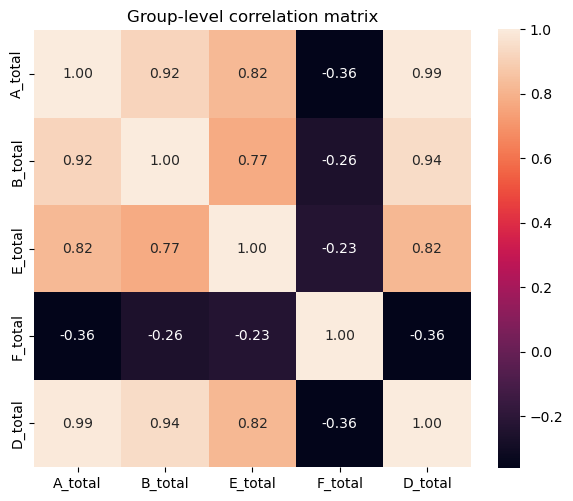

In [13]:

# -------------------------
# 4. Exploratory statistics & visualizations (minimal plots - one chart per plot)
# -------------------------
# Correlation across groups (pairwise)
corr_cols = [c for c in ['A_total','B_total','E_total','F_total','D_total'] if c in group_df.columns]
if len(corr_cols) >= 2:
    corr = group_df[corr_cols].corr()
    print("Pairwise correlations (groups):")
    display(corr)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Group-level correlation matrix")
    plt.tight_layout()
    plt.show()


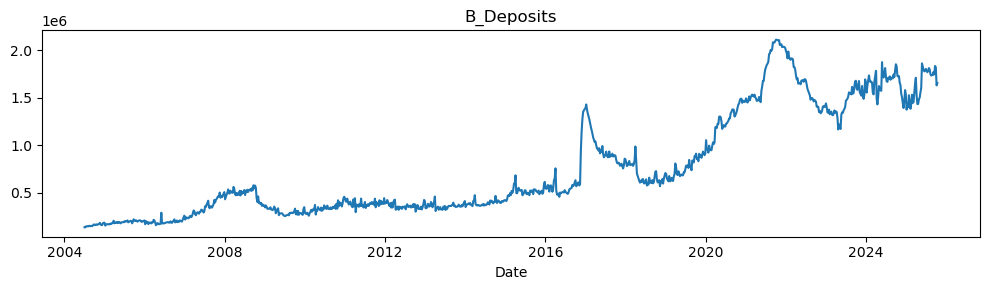

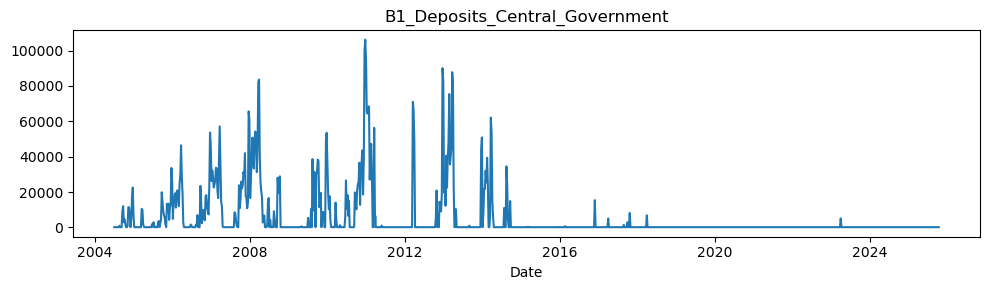

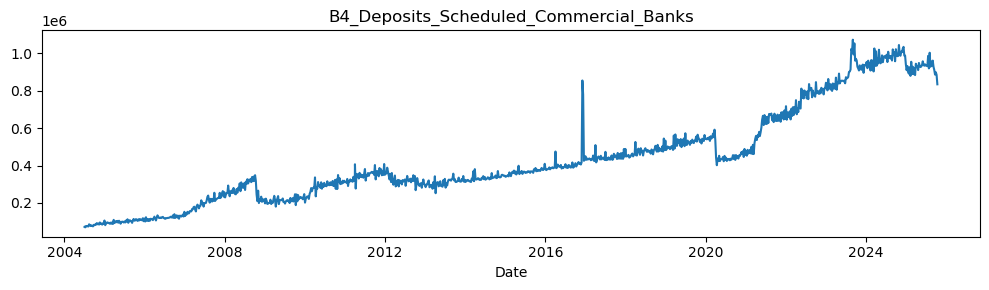

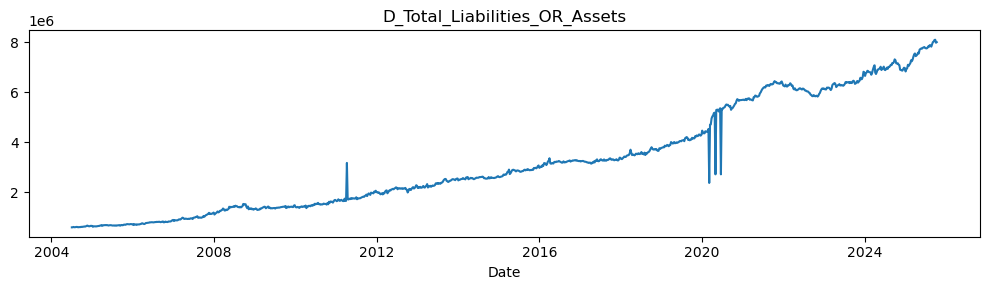

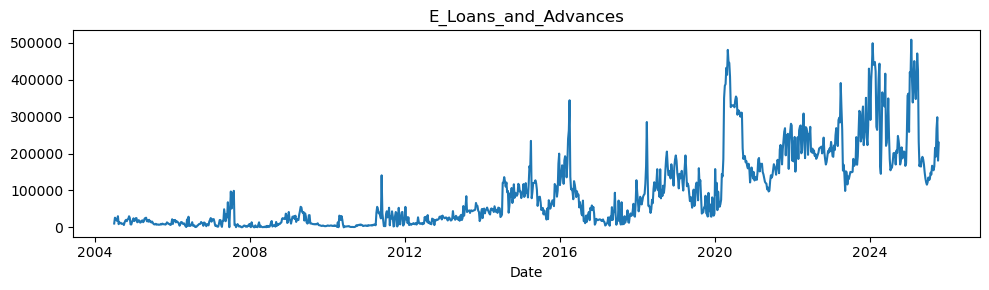

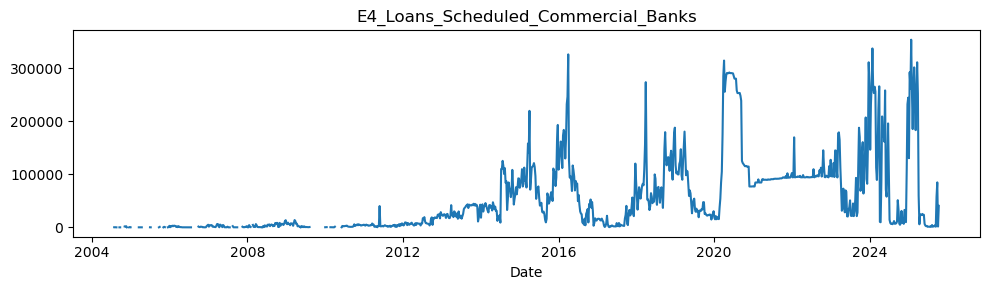

In [27]:
cols = ['B_Deposits',
        'B1_Deposits_Central_Government',
        'B4_Deposits_Scheduled_Commercial_Banks',
        'D_Total_Liabilities_OR_Assets',
        'E_Loans_and_Advances',
        'E4_Loans_Scheduled_Commercial_Banks',
        ]
present = [c for c in cols if c in df.columns]
for c in present:
    plt.figure(figsize=(10,3))
    plt.plot(df.index, df[c])
    plt.title(c)
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

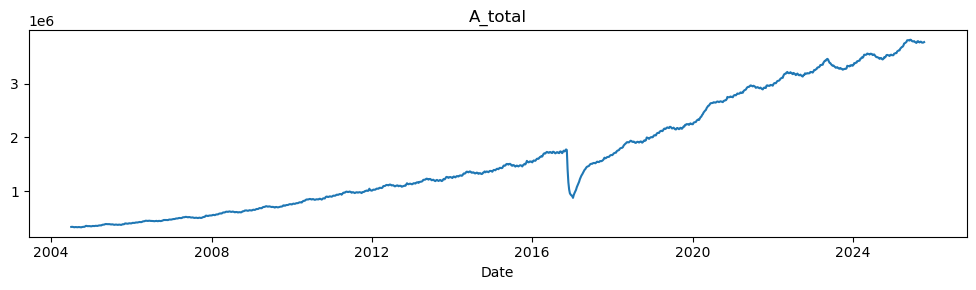

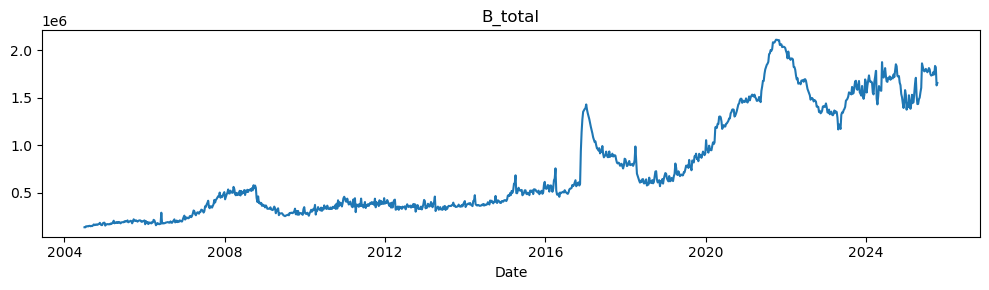

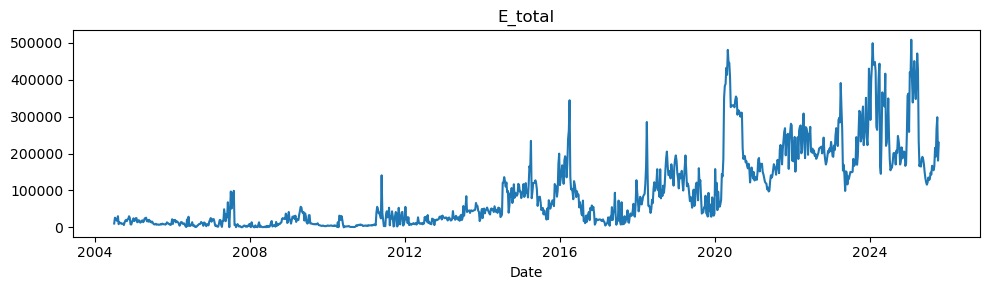

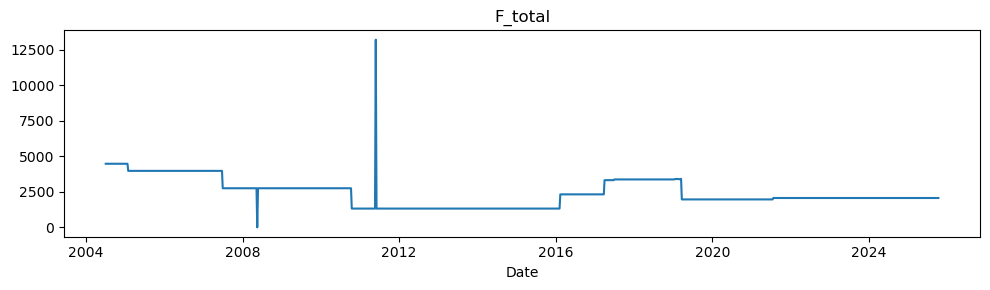

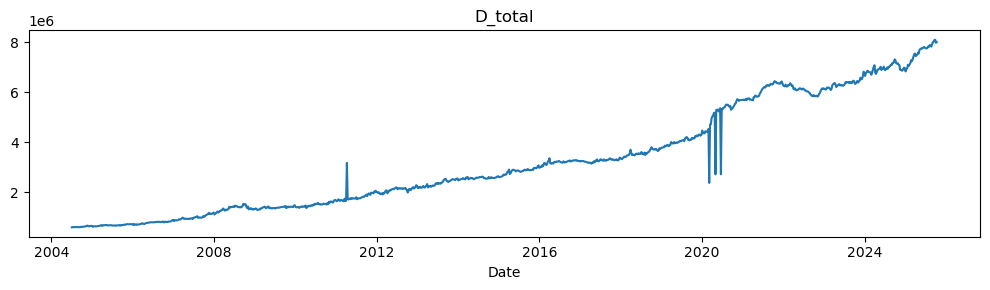

In [14]:
# Time-series plots (one plot per series)
for c in corr_cols:
    plt.figure(figsize=(10,3))
    plt.plot(group_df.index, group_df[c])
    plt.title(c)
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

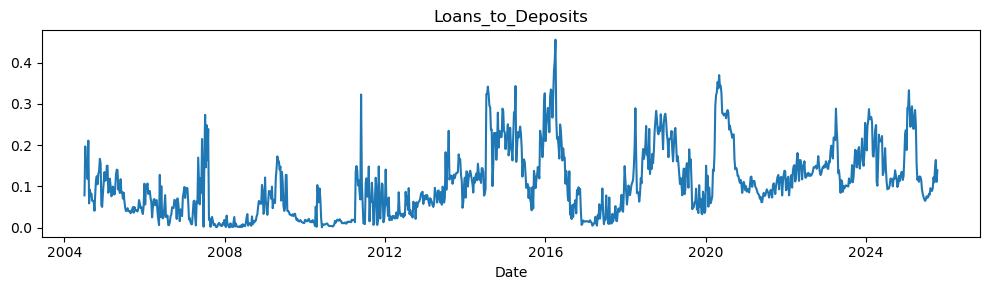

In [15]:
# Rolling Loans-to-Deposits ratio plot
if 'Loans_to_Deposits' in group_df.columns:
    plt.figure(figsize=(10,3))
    plt.plot(group_df.index, group_df['Loans_to_Deposits'])
    plt.title("Loans_to_Deposits")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

In [16]:
# -------------------------
# 5. Stationarity tests (ADF, KPSS) for selected group series
# -------------------------
def adf_test(series, name):
    series = series.dropna()
    if len(series) < 10:
        return None
    res = adfuller(series, autolag='AIC')
    return {'name': name, 'adf_stat': res[0], 'pvalue': res[1], 'nobs': res[3], 'usedlag': res[2]}

def kpss_test(series, name):
    series = series.dropna()
    if len(series) < 10:
        return None
    try:
        res = kpss(series, nlags='auto')
        return {'name': name, 'kpss_stat': res[0], 'pvalue': res[1], 'usedlags': res[2]}
    except:
        return None

stat_tests = []
for c in corr_cols:
    s = group_df[c]
    adf = adf_test(s, c)
    kps = kpss_test(s, c)
    stat_tests.append({'series': c, 'adf': adf, 'kpss': kps})
print("Stationarity test results (ADF & KPSS) summary:")
for item in stat_tests:
    print(item['series'], "ADF:", item['adf']['pvalue'] if item['adf'] else None,
          "KPSS:", item['kpss']['pvalue'] if item['kpss'] else None)

Stationarity test results (ADF & KPSS) summary:
A_total ADF: 0.9957564443571594 KPSS: 0.01
B_total ADF: 0.8318483901266067 KPSS: 0.01
E_total ADF: 0.05262924041812418 KPSS: 0.01
F_total ADF: 0.09687816317760473 KPSS: 0.01
D_total ADF: 0.9984341169134276 KPSS: 0.01


In [17]:
# -------------------------
# 6. Cointegration tests between core series (Johansen)
# -------------------------
# Johansen requires multiple series and enough observations
joh_cols = [c for c in ['B_total','E_total','F_total','D_total'] if c in group_df.columns]
if len(joh_cols) >= 2 and len(group_df.dropna(subset=joh_cols)) > (len(joh_cols) * 5):
    jc_data = group_df[joh_cols].dropna()
    # choose lag based on simple heuristic (e.g., 1)
    try:
        joh_res = coint_johansen(jc_data.values, det_order=0, k_ar_diff=1)
        print("Johansen trace statistics (eigenvalues):")
        print("LR test vals:", joh_res.lr1)   # trace statistic
        print("Critical values (90,95,99):")
        print(joh_res.cvt)
    except Exception as e:
        print("Johansen test failed:", e)

Johansen trace statistics (eigenvalues):
LR test vals: [1.30810435e+02 5.41947928e+01 1.26805487e+01 1.75434605e-02]
Critical values (90,95,99):
[[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [18]:
# -------------------------
# 7. Granger causality tests (group-level) -- pairwise
# -------------------------
# Test if B_total (Deposits) Granger-causes E_total (Loans) and vice-versa
gc_pairs = []
if 'B_total' in group_df.columns and 'E_total' in group_df.columns:
    df_gc = group_df[['B_total','E_total']].dropna()
    maxlag = 6
    try:
        print("Granger causality test (B_total -> E_total) up to lag", maxlag)
        grangercausalitytests(df_gc[['E_total','B_total']], maxlag=maxlag, verbose=False)
        print("Granger causality test (E_total -> B_total) up to lag", maxlag)
        grangercausalitytests(df_gc[['B_total','E_total']], maxlag=maxlag, verbose=False)
    except Exception as e:
        print("Granger test error:", e)

Granger causality test (B_total -> E_total) up to lag 6
Granger causality test (E_total -> B_total) up to lag 6


Selected VAR lag p (AIC): 8
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 26, Oct, 2025
Time:                     19:53:31
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    77.5315
Nobs:                     881.000    HQIC:                   77.0891
Log likelihood:          -38705.4    FPE:                2.29331e+33
AIC:                      76.8152    Det(Omega_mle):     1.97962e+33
--------------------------------------------------------------------
Results for equation B_total
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const          -9163.078874      5572.201027           -1.644           0.100
L1.B_total         0.901795         0.040636           22.192           0.000
L1.E_total        -0.091077         0.0635

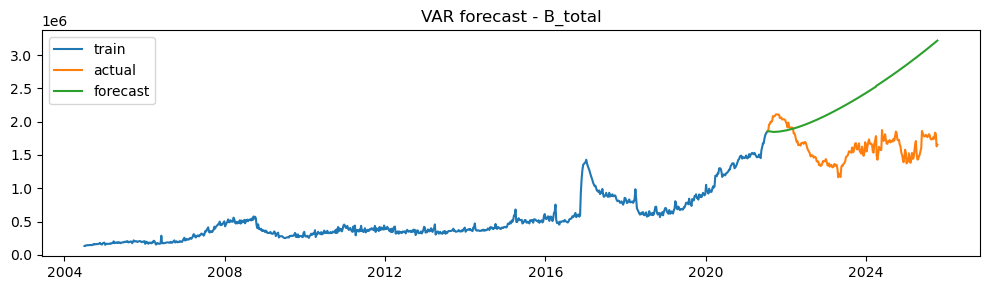

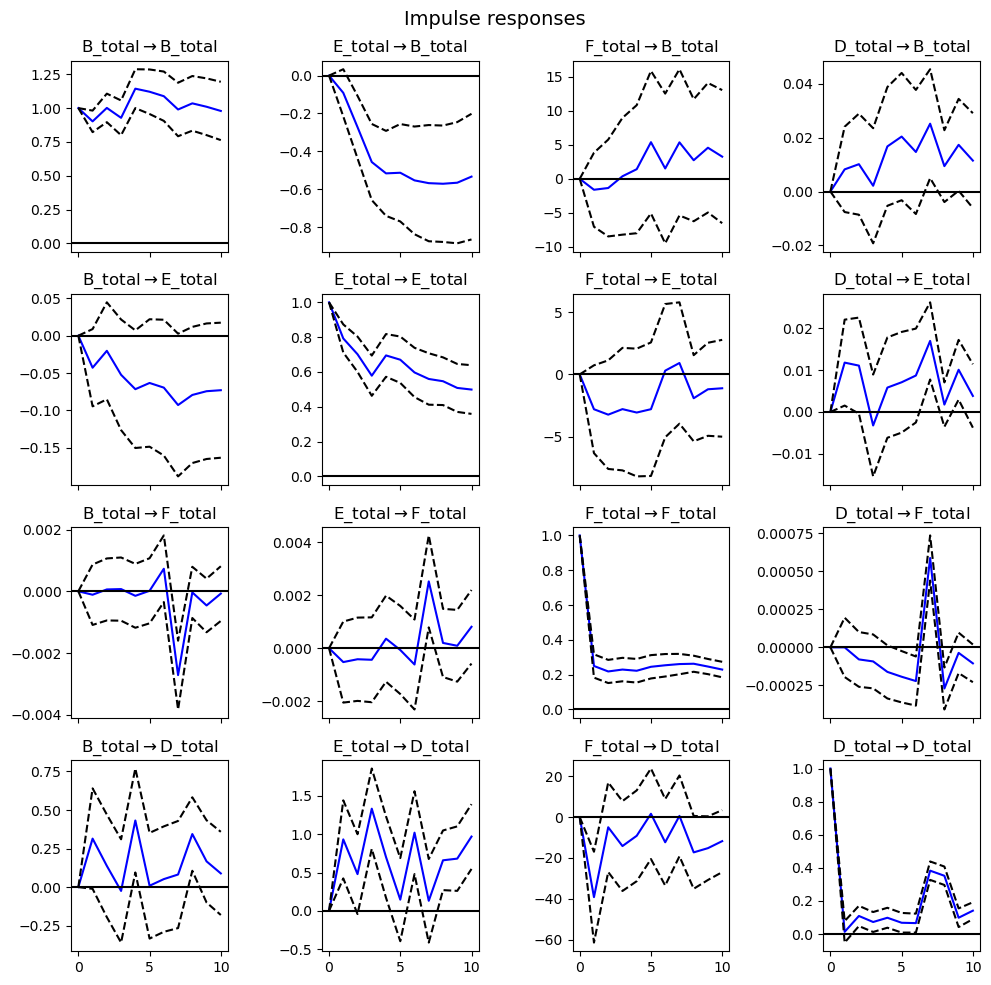

In [19]:
# -------------------------
# 8. VAR modelling (multivariate forecasting & impulse responses)
# -------------------------
var_cols = [c for c in ['B_total','E_total','F_total','D_total'] if c in group_df.columns]
var_df = group_df[var_cols].dropna()
if var_df.shape[0] > 60 and var_df.shape[1] >= 2:
    # split train/test
    train_n = int(0.8 * len(var_df))
    train_v = var_df.iloc[:train_n]
    test_v = var_df.iloc[train_n:]
    model_var = VAR(train_v)
    sel = model_var.select_order(8)
    p = sel.selected_orders.get('aic', None) or 1
    print("Selected VAR lag p (AIC):", p)
    var_res = model_var.fit(p)
    print(var_res.summary())
    # Forecast and evaluate
    steps = len(test_v)
    lag_order = var_res.k_ar
    forecast_input = train_v.values[-lag_order:]
    try:
        fc = var_res.forecast(y=forecast_input, steps=steps)
        fc_df = pd.DataFrame(fc, index=test_v.index, columns=train_v.columns)
        # RMSE per variable
        for col in train_v.columns:
            rmse = math.sqrt(mean_squared_error(test_v[col], fc_df[col]))
            print(col, "VAR RMSE:", rmse)
        # plot first variable
        plt.figure(figsize=(10,3))
        plt.plot(train_v.index, train_v.iloc[:,0], label='train')
        plt.plot(test_v.index, test_v.iloc[:,0], label='actual')
        plt.plot(fc_df.index, fc_df.iloc[:,0], label='forecast')
        plt.legend()
        plt.title(f"VAR forecast - {train_v.columns[0]}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("VAR forecasting failed:", e)

    # impulse response function (IRF)
    try:
        irf = var_res.irf(10)
        irf.plot(orth=False)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("IRF failed:", e)

SARIMAX AIC: -670.4600967088735
SARIMAX RMSE on D_total: 317142.2926063523


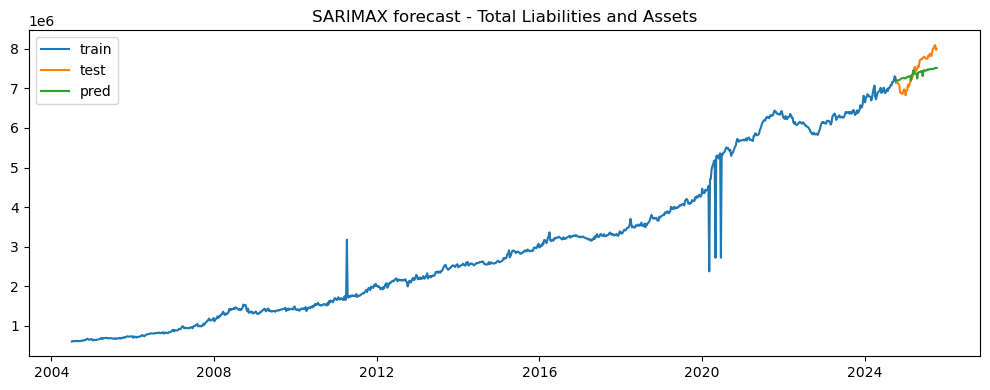

In [28]:
# -------------------------
# 9. Univariate SARIMAX example for D_total (Total Liabilities/Assets)
# -------------------------
if 'D_total' in group_df.columns:
    s = group_df['D_total'].dropna()
    if len(s) > 30:
        test_size = 52 if len(s) > 200 else max(4, int(0.2*len(s)))
        train, test = s[:-test_size], s[-test_size:]
        try:
            # scale series (optional) to aid numeric stability
            scale = 1.0
            if train.abs().max() > 1e6:
                scale = 1e6
            model = SARIMAX(train/scale, order=(1,1,1), seasonal_order=(0,1,1,52),
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=200)
            print("SARIMAX AIC:", res.aic)
            pred = res.get_forecast(steps=len(test)).predicted_mean * scale
            rmse = math.sqrt(mean_squared_error(test, pred))
            print("SARIMAX RMSE on D_total:", rmse)
            # plot
            plt.figure(figsize=(10,4))
            plt.plot(train.index, train, label='train')
            plt.plot(test.index, test, label='test')
            plt.plot(test.index, pred, label='pred')
            plt.legend()
            plt.title("SARIMAX forecast - Total Liabilities and Assets")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("SARIMAX failure:", e)


In [21]:
# -------------------------
# 10. Save outputs: group metrics, correlation, VAR forecast (if produced)
# -------------------------
# Save correlation and selected outputs
if 'corr' in locals():
    corr.to_csv("dataset/RBI_group_correlation.csv")
if 'fc_df' in locals():
    fc_df.to_csv("dataset/RBI_VAR_forecast.csv")
print("All computed outputs saved under dataset/ (group metrics, correlation, VAR forecasts if available).")

All computed outputs saved under dataset/ (group metrics, correlation, VAR forecasts if available).


In [22]:
# -------------------------
# 11. Quick diagnostics export for reporting
# -------------------------
# Export summary statistics for groups
group_stats = group_df.describe().transpose()
group_stats.to_csv("dataset/RBI_group_stats_summary.csv")
print("Exported group summary statistics to dataset/RBI_group_stats_summary.csv")

Exported group summary statistics to dataset/RBI_group_stats_summary.csv


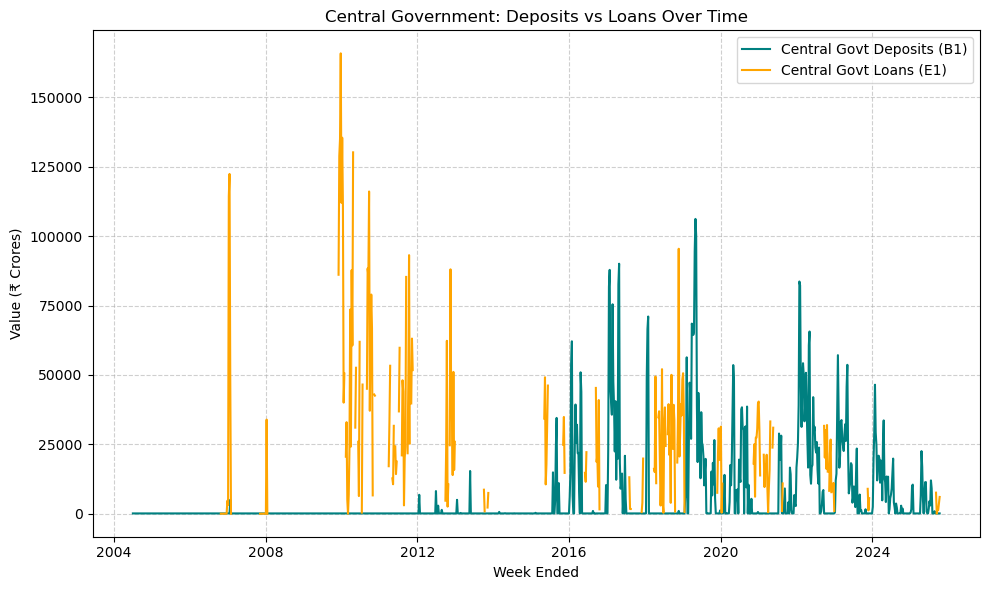

In [34]:
plt.figure(figsize=(10,6))
plt.plot(df_raw['Week_Ended'], df['B1_Deposits_Central_Government'], label='Central Govt Deposits (B1)', color='teal')
plt.plot(df_raw['Week_Ended'], df['E1_Loans_Central_Government'], label='Central Govt Loans (E1)', color='orange')
plt.title("Central Government: Deposits vs Loans Over Time")
plt.xlabel("Week Ended")
plt.ylabel("Value (₹ Crores)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

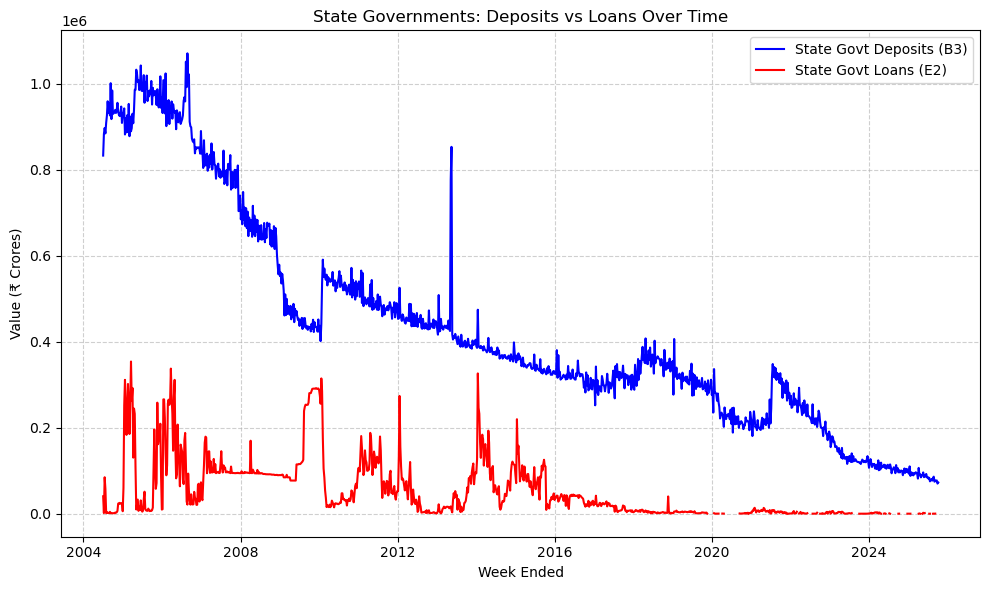

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df_raw['Week_Ended'], df['B4_Deposits_Scheduled_Commercial_Banks'], label='State Govt Deposits (B3)', color='blue')
plt.plot(df_raw['Week_Ended'], df['E4_Loans_Scheduled_Commercial_Banks'], label='State Govt Loans (E2)', color='red')
plt.title("State Governments: Deposits vs Loans Over Time")
plt.xlabel("Week Ended")
plt.ylabel("Value (₹ Crores)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [44]:
plt.figure(figsize=(10,6))
plt.plot(df_raw['Week_Ended']], df['D1_Foreign_Currency_Assets'], label='Foreign Currency Assets', color='navy')
plt.plot(df_raw['Week_Ended'], df['D2_Gold'], label='Gold', color='gold')
plt.plot(df_raw['Week_Ended'], df['D3_Rupee_Securities'], label='Rupee Securities', color='darkgreen')
plt.title("D1 vs D2 vs D3: RBI Asset Composition Over Time")
plt.xlabel("Week Ended")
plt.ylabel("Value (₹ Crores)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3187217251.py, line 2)

    Pair  Correlation
6  D1–D3     0.938909
5  D1–D2     0.887673
7  D2–D3     0.878997
2  B4–E4     0.442660
3  B5–E5     0.181929
0  B1–E1     0.073485
1  B3–E2    -0.060679
4  A1–A2    -0.191916


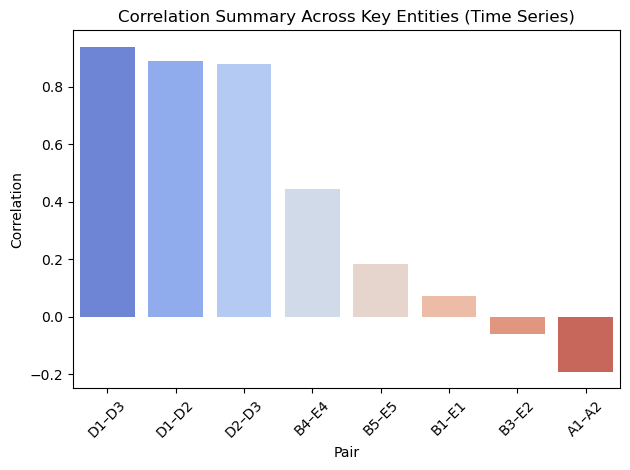

In [30]:
pairs = {
    'B1–E1': ['B1_Deposits_Central_Government', 'E1_Loans_Central_Government'],
    'B3–E2': ['B3_Deposits_State_Governments', 'E2_Loans_State_Governments'],
    'B4–E4': ['B4_Deposits_Scheduled_Commercial_Banks', 'E4_Loans_Scheduled_Commercial_Banks'],
    'B5–E5': ['B5_Deposits_Scheduled State_Cooperative_Banks', 'E5_Loans_Scheduled State_Cooperative_Banks'],
    'A1–A2': ['A1_Notes_in_Circulation', 'A2_Notes_Held_in_Banking_Department'],
}

corrs = {k: df[v[0]].corr(df[v[1]]) for k,v in pairs.items()}
corrs.update({
    'D1–D2': df['D1_Foreign_Currency_Assets'].corr(df['D2_Gold']),
    'D1–D3': df['D1_Foreign_Currency_Assets'].corr(df['D3_Rupee_Securities']),
    'D2–D3': df['D2_Gold'].corr(df['D3_Rupee_Securities'])
})

corr_df = pd.DataFrame(list(corrs.items()), columns=['Pair', 'Correlation']).sort_values('Correlation', ascending=False)
print(corr_df)

sns.barplot(data=corr_df, x='Pair', y='Correlation', palette='coolwarm')
plt.title("Correlation Summary Across Key Entities (Time Series)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
def forecast_arima(series, steps=12):
    """Fit ARIMA and forecast next `steps` periods"""
    series = series.dropna()
    model = ARIMA(series, order=(1,1,1))
    fitted = model.fit()
    forecast = fitted.forecast(steps=steps)
    return forecast, fitted


In [32]:
def forecast_prophet(df, target, date_col, periods=12):
    temp = df[[date_col, target]].rename(columns={date_col: 'ds', target: 'y'})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(temp)
    future = model.make_future_dataframe(periods=periods, freq='W')
    forecast = model.predict(future)
    
    # Plot
    model.plot(forecast)
    plt.title(f"Prophet Forecast for {target}")
    plt.xlabel("Week")
    plt.ylabel("Value (₹ Crores)")
    plt.show()
    
    return forecast


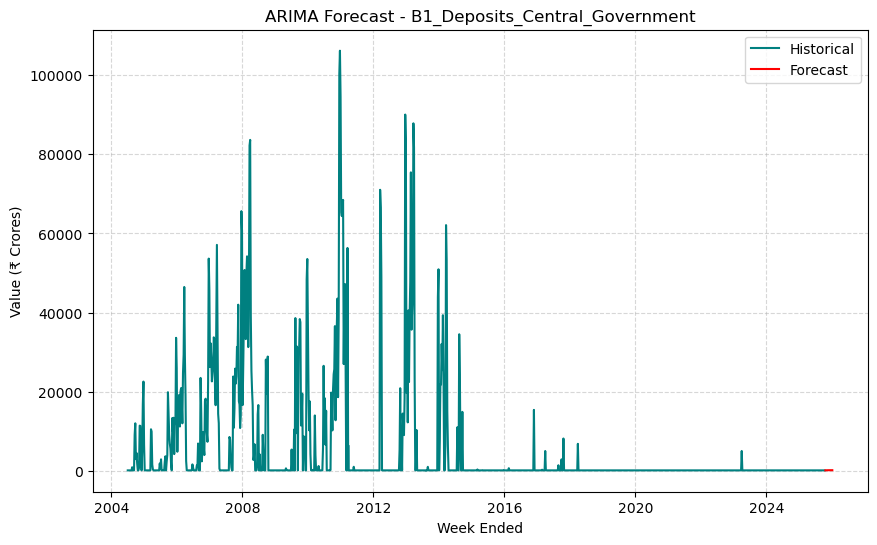

In [38]:
from statsmodels.tsa.arima.model import ARIMA
target = 'B1_Deposits_Central_Government'
series = df[target]

forecast_B1, model_B1 = forecast_arima(series, steps=12)

plt.figure(figsize=(10,6))
plt.plot(series, label='Historical', color='teal')
plt.plot(pd.date_range(series.index[-1], periods=13, freq='W')[1:], forecast_B1, label='Forecast', color='red')
plt.title(f"ARIMA Forecast - {target}")
plt.xlabel("Week Ended")
plt.ylabel("Value (₹ Crores)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual = series[-12:]
preds = forecast_B1[:len(actual)]
mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))
print(f"ARIMA Evaluation for {target} | MAE: {mae:.2f}, RMSE: {rmse:.2f}")

ARIMA Evaluation for B1_Deposits_Central_Government | MAE: 33.93, RMSE: 35.40
